In [1]:
from hossam import *
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

In [2]:
origin=load_data('restaurant_sales_preprocessed')
origin.set_index('date', inplace=True)
origin['holiday']=origin['holiday'].astype('category')
origin['weekend']=origin['weekend'].astype('category')
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sales           353 non-null    float64 
 1   visitors        353 non-null    int64   
 2   avg_price       353 non-null    int64   
 3   marketing_cost  353 non-null    float64 
 4   delivery_ratio  353 non-null    float64 
 5   rain_mm         353 non-null    float64 
 6   temperature     353 non-null    float64 
 7   holiday         353 non-null    category
 8   weekend         353 non-null    category
dtypes: category(2), float64(5), int64(2)
memory usage: 23.0 KB


In [3]:
df=origin

yname='sales'
x=df.drop(columns=[yname])
y=df[yname]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=52)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

In [5]:
%%time

pipe=Pipeline([('scaler', StandardScaler()), ('model', KNeighborsRegressor())])

param_grid={
    # 핵심 파라미터
    'model__n_neighbors':[3, 5, 7, 9, 15, 25],
    'model__weights':['uniform', 'distance'],
    # 거리 정의
    'model__metric':['euclidean', 'manhattan', 'minkowski'],
    'model__p':[
        1,
        2,
    ],  # p=1: Manhattan, p=2: Euclidean -> metric='minkowski'일 때만 p 의미 있음
    # 탐색 알고리즘 / 성능
    'model__algorithm':['auto', 'ball_tree', 'kd_tree'],
    'model__leaf_size':[20,30,40]
}

gs=GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)

gs.fit(x_train, y_train)

best_model=gs.best_estimator_

print('Best params :', gs.best_params_)
print('CV best score :', gs.best_score_)

Best params : {'model__algorithm': 'auto', 'model__leaf_size': 20, 'model__metric': 'euclidean', 'model__n_neighbors': 15, 'model__p': 1, 'model__weights': 'distance'}
CV best score : 0.6444866391028172
CPU times: total: 1.27 s
Wall time: 5.4 s


In [7]:
y_pred=best_model.predict(x_test)
result_df=DataFrame(
    {
            '결정계수(R2)': r2_score(y_test, y_pred),
            '평균절대오차(MAE)': mean_absolute_error(y_test, y_pred),
            '평균제곱오차(MSE)': mean_squared_error(y_test, y_pred),
            '평균오차(RMSE)': np.sqrt(mean_squared_error(y_test, y_pred)),
            '평균 절대 백분오차 비율(MAPE)': mean_absolute_percentage_error(y_test, y_pred),
            '평균 비율 오차(MPE)': np.mean((y_test - y_pred) / y_test * 100)
    },
    index=['성능지표']
)

result_df

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE)
성능지표,0.634869,0.178029,0.052234,0.228547,0.010843,0.301152


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import learning_curve

def hs_leanring_cv(
    estimator,
    x,
    y,
    scoring="neg_root_mean_squared_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
):
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=52,
    )

    model_name = estimator.named_steps["model"].__class__.__name__
    print(f"=== Learning Curve: {model_name} ===")

    # neg RMSE -> RMSE
    train_rmse = -train_scores
    cv_rmse = -cv_scores

    # 평균 / 표준편차
    train_mean = train_rmse.mean(axis=1)
    cv_mean = cv_rmse.mean(axis=1)
    cv_std = cv_rmse.std(axis=1)

    # 마지막 지점 기준 정량 판정
    final_train = train_mean[-1]
    final_cv = cv_mean[-1]
    final_std = cv_std[-1]
    gap_ratio = final_train / final_cv
    var_ratio = final_std / final_cv

    # ------------------
    # 과소적합 기준선 (some_threshold)
    # ------------------
    # 기준모형 RMSE (평균 예측)
    y_mean = y.mean()
    rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))

    # 분산 기반
    std_y = y.std()

    # 최소 설명력(R^2) 기반
    min_r2 = 0.10
    rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))

    # 최종 threshold (가장 관대한 기준)
    # -> 원래 some_threshold는 도메인 지식 수준에서 이 모델은 최소 어느 정도의 성능은 내야 한다는 기준을 설정하는 것
    some_threshold = min(rmse_naive, std_y, rmse_r2)

    # ------------------
    # 판정 로직
    # ------------------
    if gap_ratio >= 0.95 and final_cv > some_threshold:
        status = "⚠️ 과소적합 (bias 큼)"
    elif gap_ratio <= 0.8:
        status = "⚠️ 과대적합 (variance 큼)"
    elif gap_ratio <= 0.95 and var_ratio <= 0.10:
        status = "✅ 일반화 양호"
    elif var_ratio > 0.15:
        status = "⚠️ 데이터 부족 / 분산 큼"
    else:
        status = "⚠️ 판단 유보"

    # ------------------
    # 정량 결과 표
    # ------------------
    result_df = pd.DataFrame(
        {
            "지표": [
                "Train RMSE",
                "CV RMSE 평균",
                "CV RMSE 표준편차",
                "Train/CV 비율",
                "CV 변동성 비율",
                "판정 결과",
            ],
            "값": [
                final_train,
                final_cv,
                final_std,
                gap_ratio,
                var_ratio,
                status,
            ],
        }
    )

    display(result_df)

    # ------------------
    # 학습곡선 시각화
    # ------------------
    # my_dpi 값이 사전에 정의되어 있어야 합니다. (예: my_dpi = 96)
    figsize = (1280 / my_dpi, 720 / my_dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

    sb.lineplot(
        x=train_sizes,
        y=train_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="Train RMSE",
    )
    
    sb.lineplot(
        x=train_sizes,
        y=cv_mean,
        marker="o",
        markeredgecolor="#ffffff",
        label="CV RMSE", # 이미지에는 둘 다 Train RMSE로 되어있으나 문맥상 CV RMSE로 수정 제안
    )

    ax.set_xlabel("Sample Size", fontsize=8, labelpad=5) # 원본은 RMSE로 되어있으나 보통 x축은 샘플 수입니다.
    ax.set_ylabel("Learning Curve", fontsize=8, labelpad=5)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()

=== Learning Curve: KNeighborsRegressor ===


,지표,값
0,Train RMSE,0.0
1,CV RMSE 평균,0.219858
2,CV RMSE 표준편차,0.019821
3,Train/CV 비율,0.0
4,CV 변동성 비율,0.090153
5,판정 결과,⚠️ 과대적합 (variance 큼)


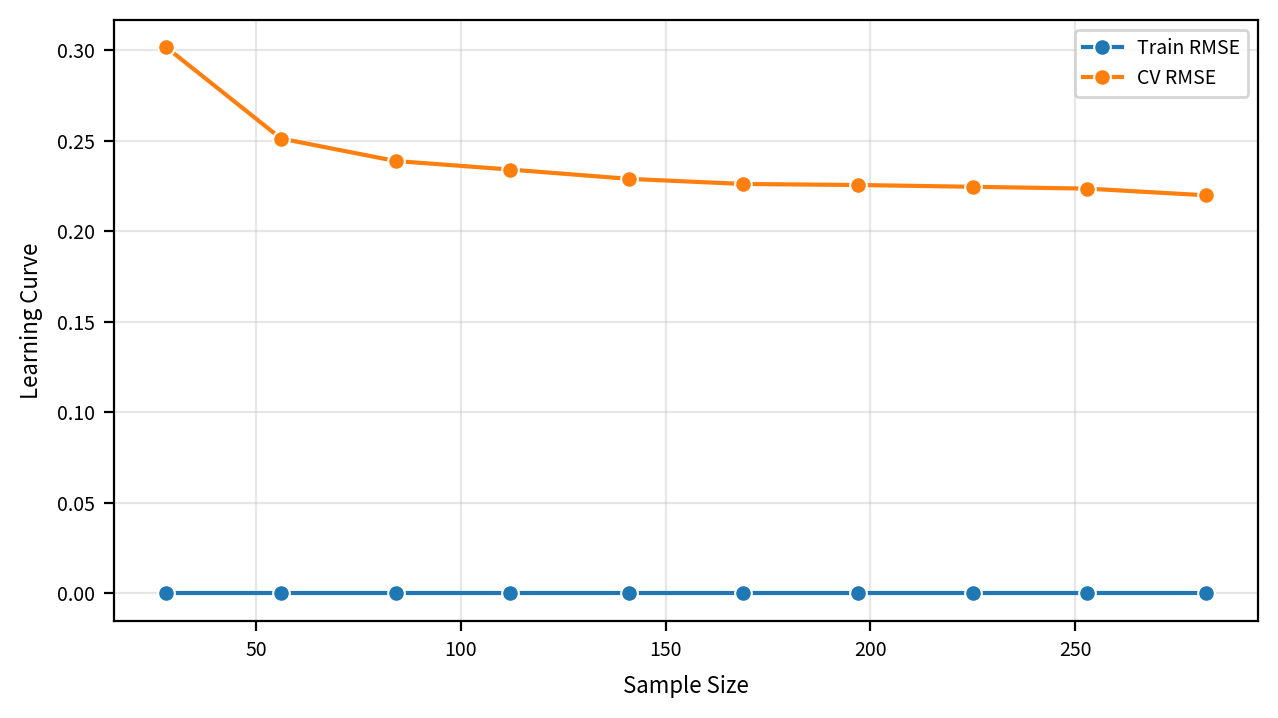

In [12]:
hs_leanring_cv(best_model, x, y)

In [14]:
perm=permutation_importance(
    estimator=best_model,
    X=x_test,
    y=y_test,
    scoring='r2',
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

perm_df=DataFrame(
    {
        'importance_mean':perm.importances_mean,
        'importance_std':perm.importances_std
    },
    index=x_test.columns
).sort_values('importance_mean', ascending=False)

perm_df

,importance_mean,importance_std
weekend,0.307000,0.055487
holiday,0.266704,0.054560
marketing_cost,0.081119,0.023776
rain_mm,0.048560,0.012672
avg_price,0.014858,0.010690
visitors,0.014034,0.011197
delivery_ratio,-0.002298,0.010469
temperature,-0.005803,0.010518


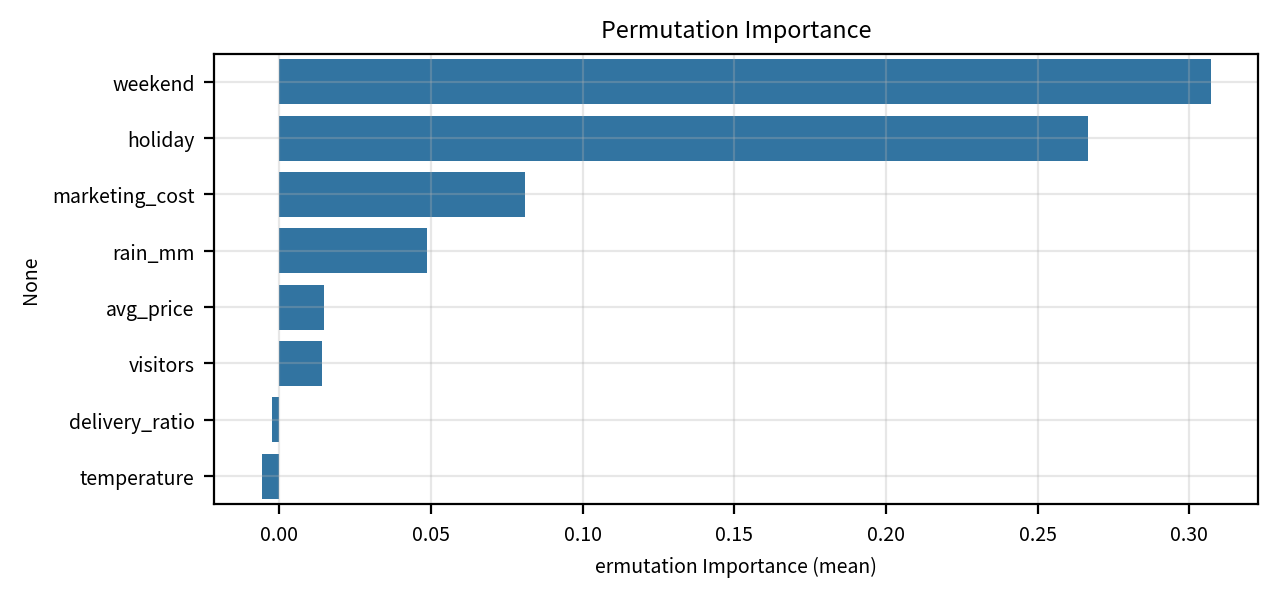

In [15]:
df=perm_df.sort_values(by='importance_mean', ascending=False)

figsize=(1280/my_dpi, 600/my_dpi)
fig, ax=plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.barplot(data=df, x='importance_mean', y=df.index)

ax.set_title('Permutation Importance')
ax.set_xlabel('ermutation Importance (mean)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()